# Computing the Jacobian for a toy stellar spectral model.

*Natasha Batalha & Gully, 12/13/2019, Ames Hack Day*  

In this notebook we make a toy stellar spectrum model.  The model is purposely unphysical to keep it simple:

$$\mathbf{f(\vec{\theta})} = f_\lambda(T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}])$$


The goal of this notebook is to show that we can compute the [Jacobian Matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) of the spectrum.  That is, the derivative of the spectrum, $f_\lambda$ with respect to each parameter, $T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}]$:

$$ \frac{\partial \mathbf{f}}{\partial \vec{\theta} } = \frac{\partial f_\lambda}{\partial T_{\mathrm{eff} }}, \frac{\partial f_\lambda}{\partial \log{g}}, \frac{\partial f_\lambda}{\partial [\mathrm{Fe}/\mathrm{H}]}$$

The first step is to **override** numpy with a version that tracks the instruction set of primitive functions, and applies the chain rule to their derivatives.  We'll use [jax](https://github.com/google/jax).

In [1]:
#import numpy as np
import jax.numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The data exist as a table of wavelength, flux, and flux uncertainty.  
You can think of the wavelength values as corresponding to the near-IR in micron.

In [3]:
wl = np.linspace(2.0, 2.4, 10000)

/Users/obsidian/anaconda3/envs/TgiF/lib/python3.7/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


The specrral lines will all be absorption lines with Gaussian line profiles:
$$ $$
$$\mathrm{abs}(\lambda) = A \cdot e^{-\frac{1}{2}\left((\lambda-\lambda_0)/\sigma\right)^2 }$$

The free paramters for the line are the line center position $\lambda_0$, depth $A$, and linewidth $\sigma$.

In [4]:
def line_profile(location, depth, width):
    """Make a spectral line"""
    return depth * np.exp(-0.5*((wl-location)/width)**2)

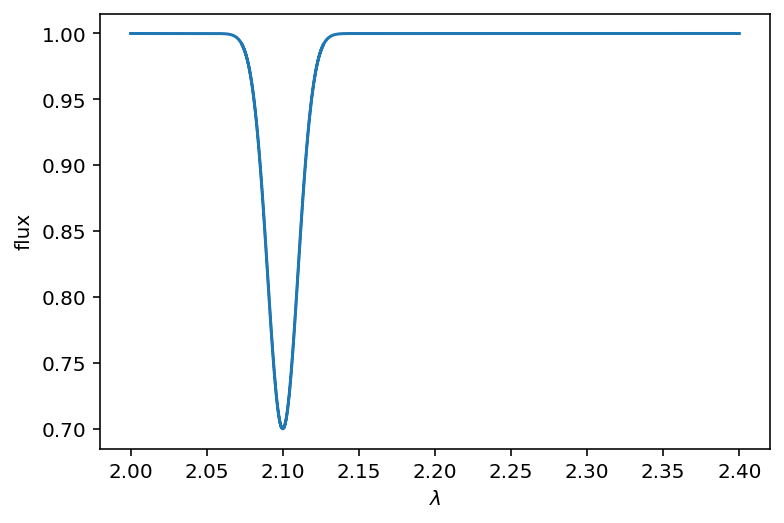

In [5]:
plt.step(wl, 1-line_profile(2.1, 0.3, 0.01))
plt.xlabel('$\lambda$'); plt.ylabel('flux');

We're going to make a function that generates fake flux values.
This spectrum has 3 distinct lines:  
- $\lambda=2.1$ the amplitude depends only on $T_{\mathrm{eff}}$
- $\lambda=2.2$ the linewidth depends only on $\log{g}$
- $\lambda=2.3$ increases linearly with $[\mathrm{Fe}/\mathrm{H}]$

In [6]:
def synthetic_spectrum(a):
    """generate a synthetic spectrum"""
    teff, logg, fe_h = a 
    amp1 = 0.6*np.exp(-((teff-2700)/500)**2)
    line1 = line_profile(2.1, amp1, 0.01)
    
    width2 = 0.01 + 0.002*(0.5+np.arctan( ((logg - 3)/0.5) / (np.pi/4) ))
    line2 = line_profile(2.2, 0.3, width2)
    
    amp3 = 0.0 + 0.1*np.sqrt(6+fe_h)
    line3 = line_profile(2.3, amp3, 0.01)
    
    net_flux = 1 - (line1 + line2 + line3)
    return net_flux

In [7]:
flux = synthetic_spectrum((2700, 3.5, 0.0))

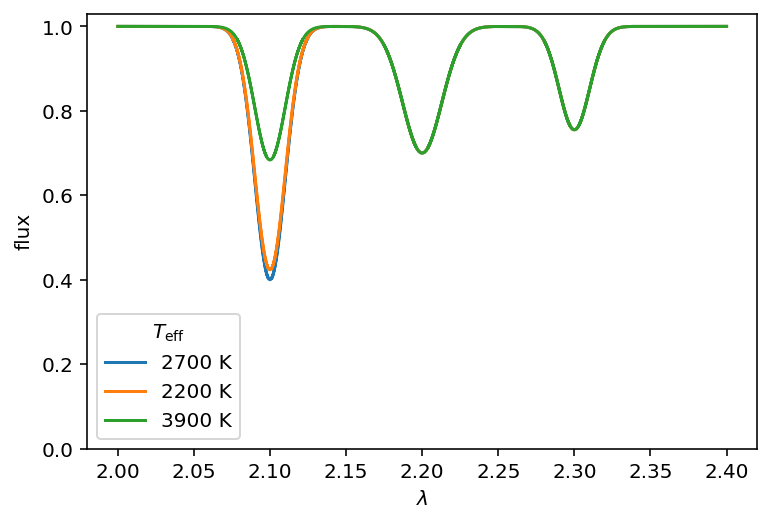

In [8]:
plt.step(wl, flux, label='2700 K');
plt.step(wl, synthetic_spectrum((2600, 3.5, 0.0)), label='2200 K')
plt.step(wl, synthetic_spectrum((3100, 3.5, 0.0)), label='3900 K')
plt.xlabel('$\lambda$'); plt.ylabel('flux');plt.legend(loc='best', title='$T_{\mathrm{eff}}$');plt.ylim(0);

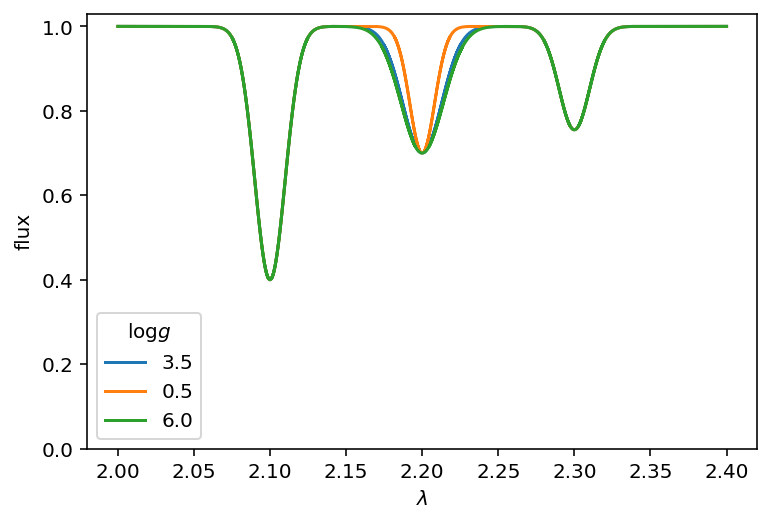

In [9]:
plt.step(wl, flux, label='3.5');
plt.step(wl, synthetic_spectrum((2700, 0.5, 0.0)), label='0.5')
plt.step(wl, synthetic_spectrum((2700, 6.0, 0.0)), label='6.0')
plt.xlabel('$\lambda$'); plt.ylabel('flux');plt.legend(loc='best', title='$\log{g}$');plt.ylim(0);

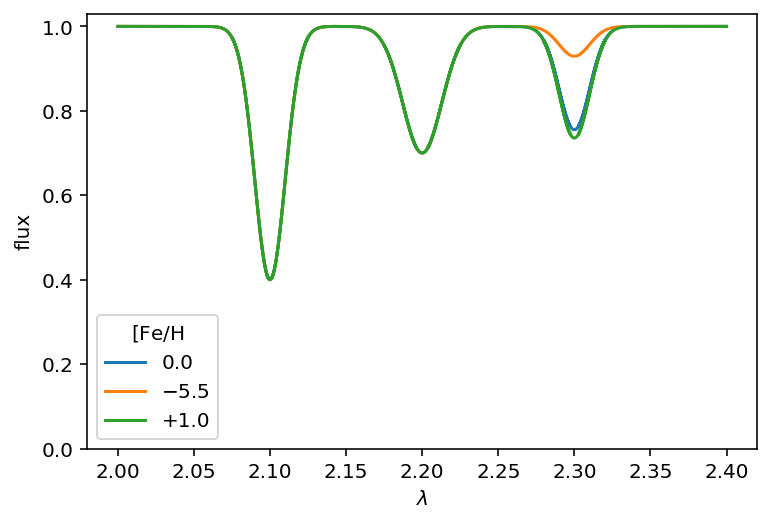

In [10]:
plt.step(wl, flux, label='0.0');
plt.step(wl, synthetic_spectrum((2700, 3.5, -5.5)), label='$-5.5$')
plt.step(wl, synthetic_spectrum((2700, 3.5, 1.0)), label='+1.0')
plt.xlabel('$\lambda$'); plt.ylabel('flux');plt.legend(loc='best', title='$[\mathrm{Fe}/\mathrm{H}$');plt.ylim(0);

Next step: use jax to get: 
$$\frac{\partial f_\lambda}{\partial T_{\mathrm{eff} }}, \frac{\partial f_\lambda}{\partial \log{g}}, \frac{\partial f_\lambda}{\partial [\mathrm{Fe}/\mathrm{H}]}$$

In [11]:
from jax import grad, jit, vmap, jacfwd, jacrev

In [12]:
%time 
forward_mode_jacobian = jacfwd(synthetic_spectrum)((3000.0, 0.1, 0.0))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [13]:
%time 
reverse_mode_jacobian = jacrev(synthetic_spectrum)((3000.0, 0.1, 0.0))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


In [20]:
labels = [r'$\frac{\partial f_\lambda}{\partial T_{\mathrm{eff} }}$',
          r'$\frac{\partial f_\lambda}{\partial \log{g}}$',
          r'$\frac{\partial f_\lambda}{\partial [\mathrm{Fe}/\mathrm{H}]}$']

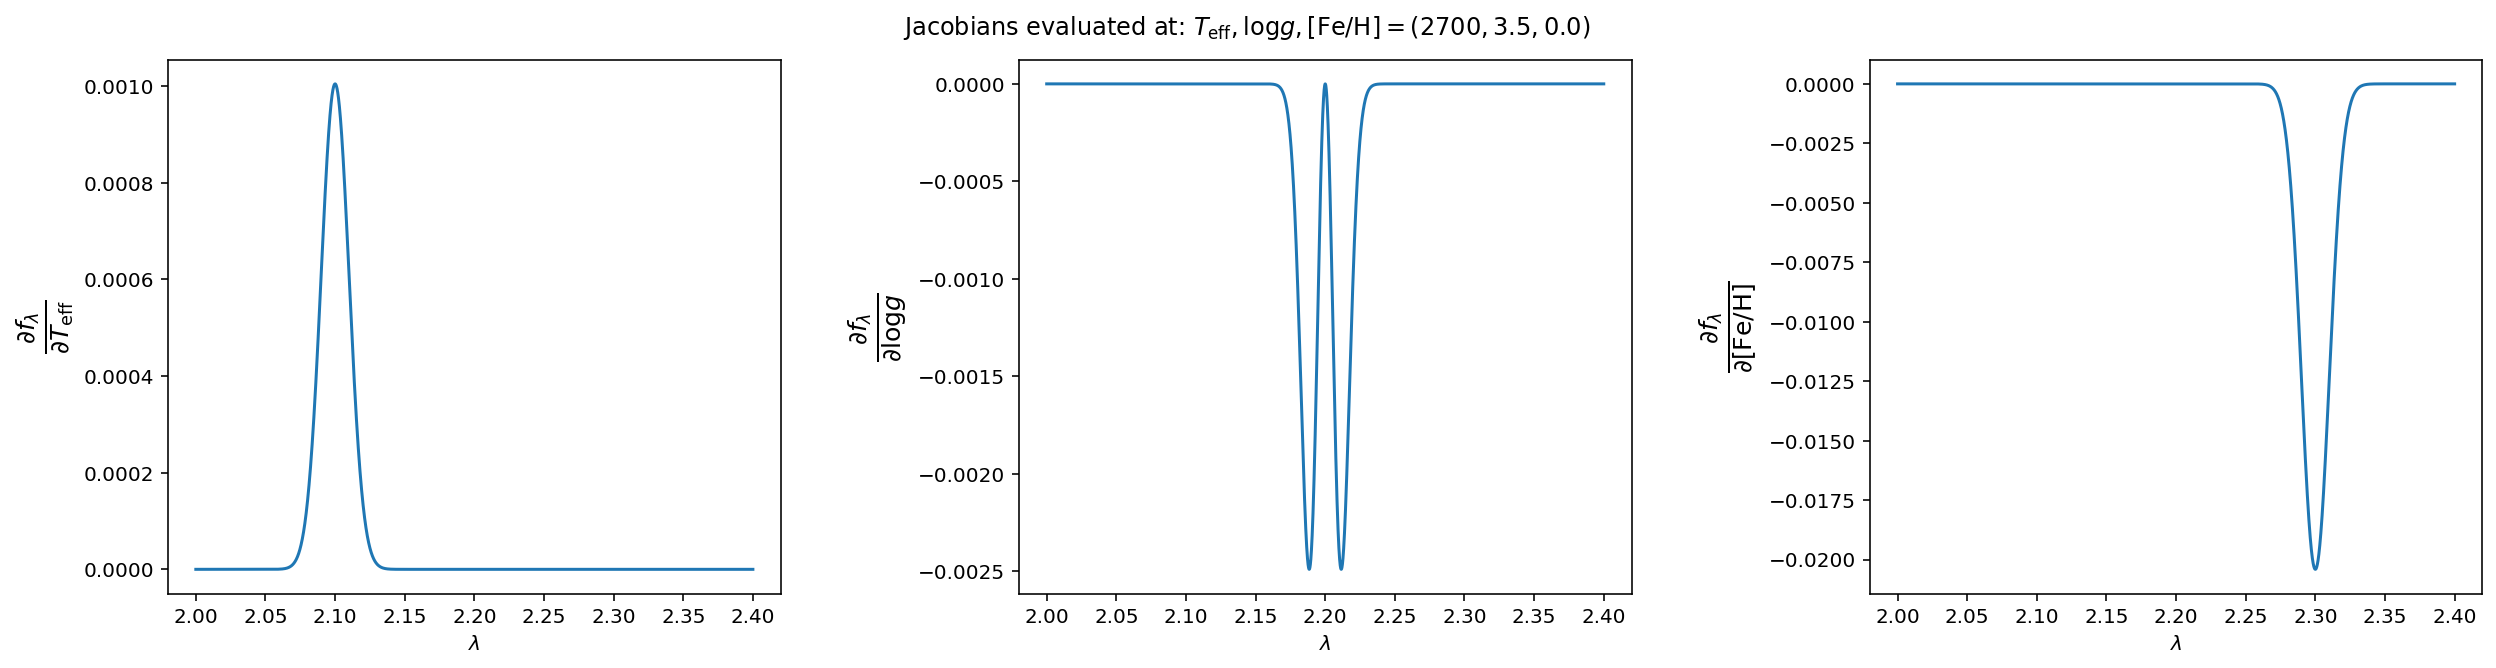

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, partial_derivative in enumerate(forward_mode_jacobian): 
    axes[i].plot(wl,partial_derivative, label = labels[i]);
    axes[i].set_xlabel('$\lambda$'); axes[i].set_ylabel(labels[i], fontsize=18) 
fig.suptitle('Jacobians evaluated at: $T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}] = (2700, 3.5, 0.0)$')
plt.tight_layout(pad=3);

Awesome!  We computed exact Jacobians instantly!  Each plot shows the partial derivative of the spectrum with respect to a stellar parameter.

### Open questions

Now we can ask some more questions:

1. How does Jax deal with *tiered* input, such as $\vec{\theta} = \big\{(T_1, T_2, T_3), \log{g}, [\mathrm{Fe}/{\mathrm{H}}]\big\}$ ?
2. What if a single spectral line depends on multiple stellar parameters, instead of just one?
3. How about applying Jax to real data?  Can we use gradient descent of the likelihood function?
4. How do the results compare to *numerical* derivatives?

### 1. Tiered handling of parameters
The inputs to real-world synthetic spectral model functions are lists, and perhaps *lists of lists*.  Operationally, how does Jax handle this so called "tiered" input?  Let's find out!  
Here is a function with 5 total inputs: $(T_1, T_2, T_3)$, repacing the scalar value for $T_{\mathrm{eff}}$.

In [65]:
def synthetic_spectrum_tiered(a):
    """generate a synthetic spectrum"""
    teff, logg, fe_h = a 
    t1, t2, t3 = teff
    amp1 = (0.2*np.exp(-((t1-1200)/300)**2) +
           0.3*np.exp(-((t2-1250)/400)**2) +
           0.4*np.exp(-((t3-1300)/500)**2) )
    line1 = line_profile(2.1, amp1, 0.01)
    
    width2 = 0.01 + 0.002*(0.5+np.arctan( ((logg - 3)/0.5) / (np.pi/4) ))
    line2 = line_profile(2.2, 0.3, width2)
    
    amp3 = 0.0 + 0.1*np.sqrt(6+fe_h)
    line3 = line_profile(2.3, amp3, 0.01)
    
    net_flux = 1 - (line1 + line2 + line3)
    return net_flux

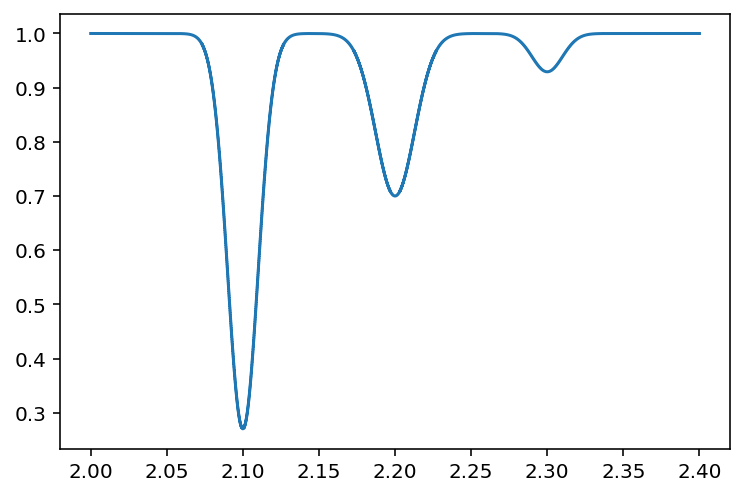

In [67]:
plt.step(wl, synthetic_spectrum_tiered(((1000,1400,1500), 3.5, -5.5)));

Here is the function evaluated at an input with five parameters.

In [69]:
F_tiered = jacfwd(synthetic_spectrum_tiered)(((1000.0,1400.0,1500.0), 0.1, 0.0))

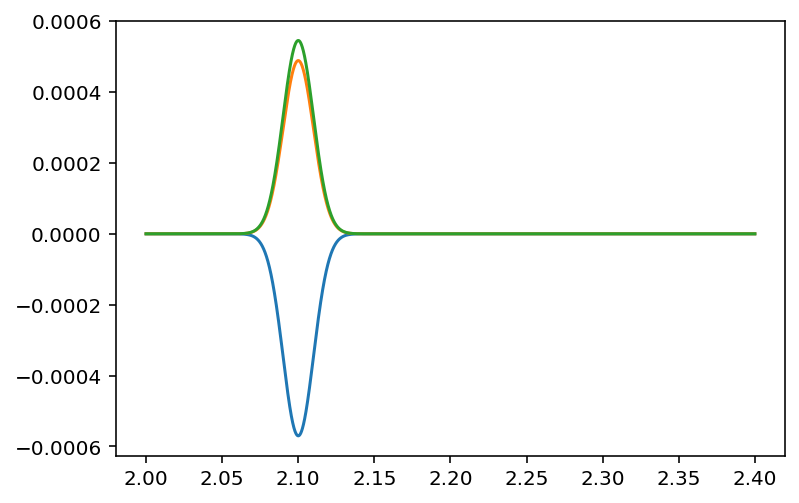

In [70]:
for i in F_tiered[0]: plt.plot(wl,i)

In [88]:
temp_jacobians, log_g_jacobian, fe_h_jacobian = F_tiered

In [92]:
temp_jacobians[0].shape, temp_jacobians[1].shape, temp_jacobians[2].shape, log_g_jacobian.shape, fe_h_jacobian.shape

((10000,), (10000,), (10000,), (10000,), (10000,))

It works!  Jax returns a tiered structure of tuples that the user can unpack and index into as above.

## What if a single spectral line depends on multiple stellar parameters, instead of just one?

In [97]:
def synthetic_spectrum_confounded(a):
    """generate a synthetic spectrum"""
    teff, logg, fe_h = a 

    amp1 = 0.3*np.exp(-((teff-2700)/500)**2) + 0.1*np.sqrt(6+fe_h)
    width1 = 0.01 + 0.002*(0.5+np.arctan( ((logg - 3)/0.5) / (np.pi/4) ))
    line1 = line_profile(2.2, amp1, width1)
    
    net_flux = 1 - (line1)
    return net_flux

In [98]:
flux = synthetic_spectrum_confounded((2700, 3.5, 0.0))

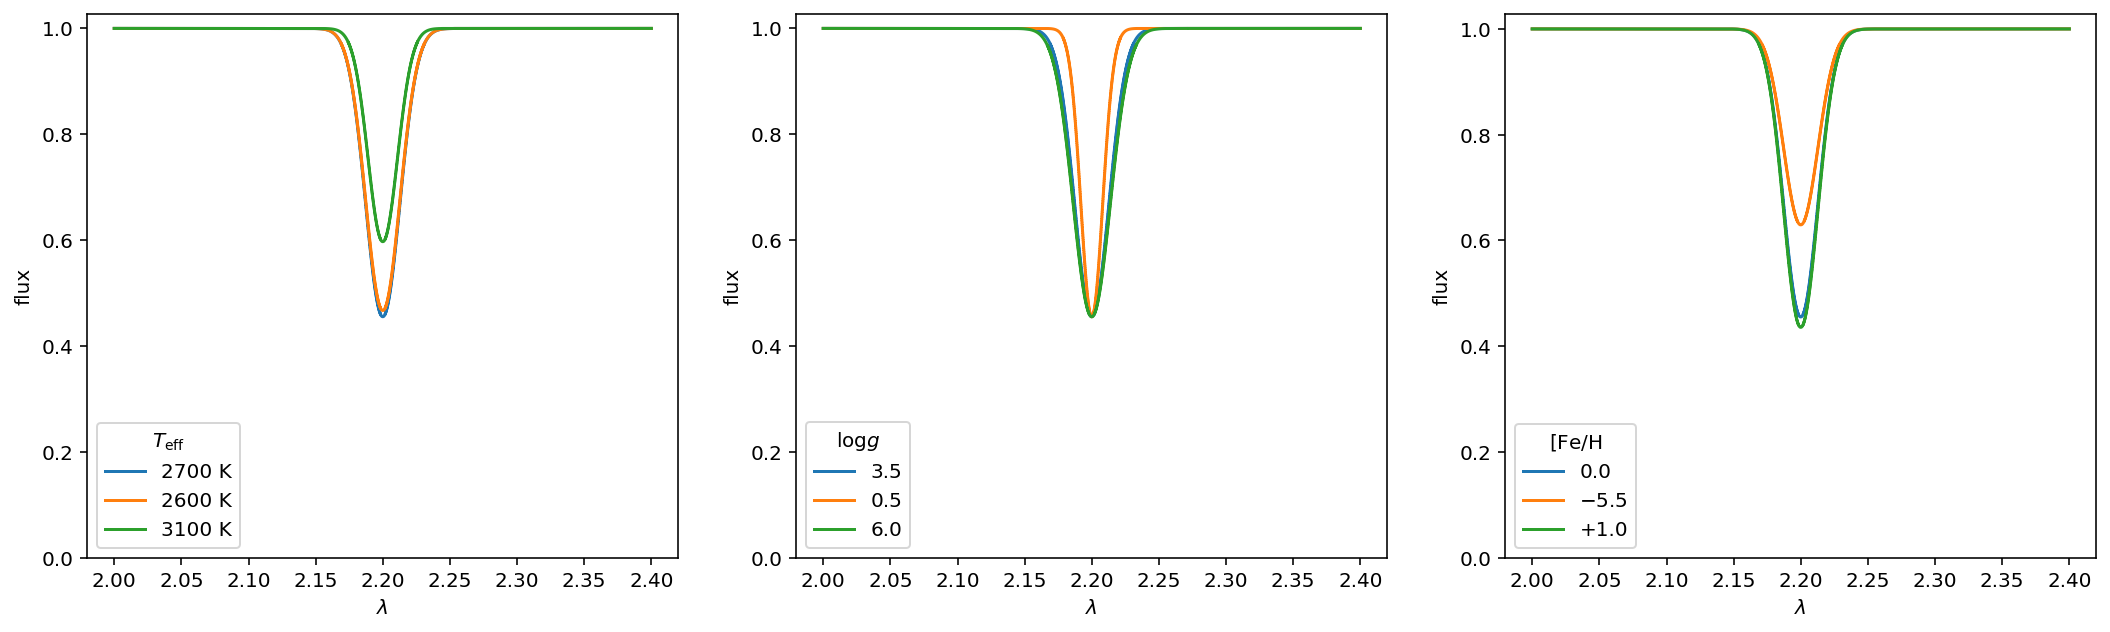

In [108]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].step(wl, flux, label='2700 K');
axes[0].step(wl, synthetic_spectrum_confounded((2600, 3.5, 0.0)), label='2600 K')
axes[0].step(wl, synthetic_spectrum_confounded((3100, 3.0, 0.0)), label='3100 K')
axes[0].set_xlabel('$\lambda$'); axes[0].set_ylabel('flux');axes[0].legend(loc='best', title='$T_{\mathrm{eff}}$');axes[0].set_ylim(0);

axes[1].step(wl, flux, label='3.5');
axes[1].step(wl, synthetic_spectrum_confounded((2700, 0.5, 0.0)), label='0.5')
axes[1].step(wl, synthetic_spectrum_confounded((2700, 6.0, 0.0)), label='6.0')
axes[1].set_xlabel('$\lambda$'); axes[1].set_ylabel('flux');axes[1].legend(loc='best', title='$\log{g}$');axes[1].set_ylim(0);


axes[2].step(wl, flux, label='0.0');
axes[2].step(wl, synthetic_spectrum_confounded((2700, 3.5, -5.5)), label='$-5.5$')
axes[2].step(wl, synthetic_spectrum_confounded((2700, 3.5, 1.0)), label='+1.0')
axes[2].set_xlabel('$\lambda$'); axes[2].set_ylabel('flux');axes[2].legend(loc='best', title='$[\mathrm{Fe}/\mathrm{H}$');axes[2].set_ylim(0);

Messy!  The line depends on all three parameters!  This scenario is common in astrophysics and more physically realistic.  
It's hard to tell the derivative from these visualizations alone.  Let's see the Jacobian!

In [112]:
F_confounded = jacfwd(synthetic_spectrum_confounded)((2900.0, 3.7, 0.3))

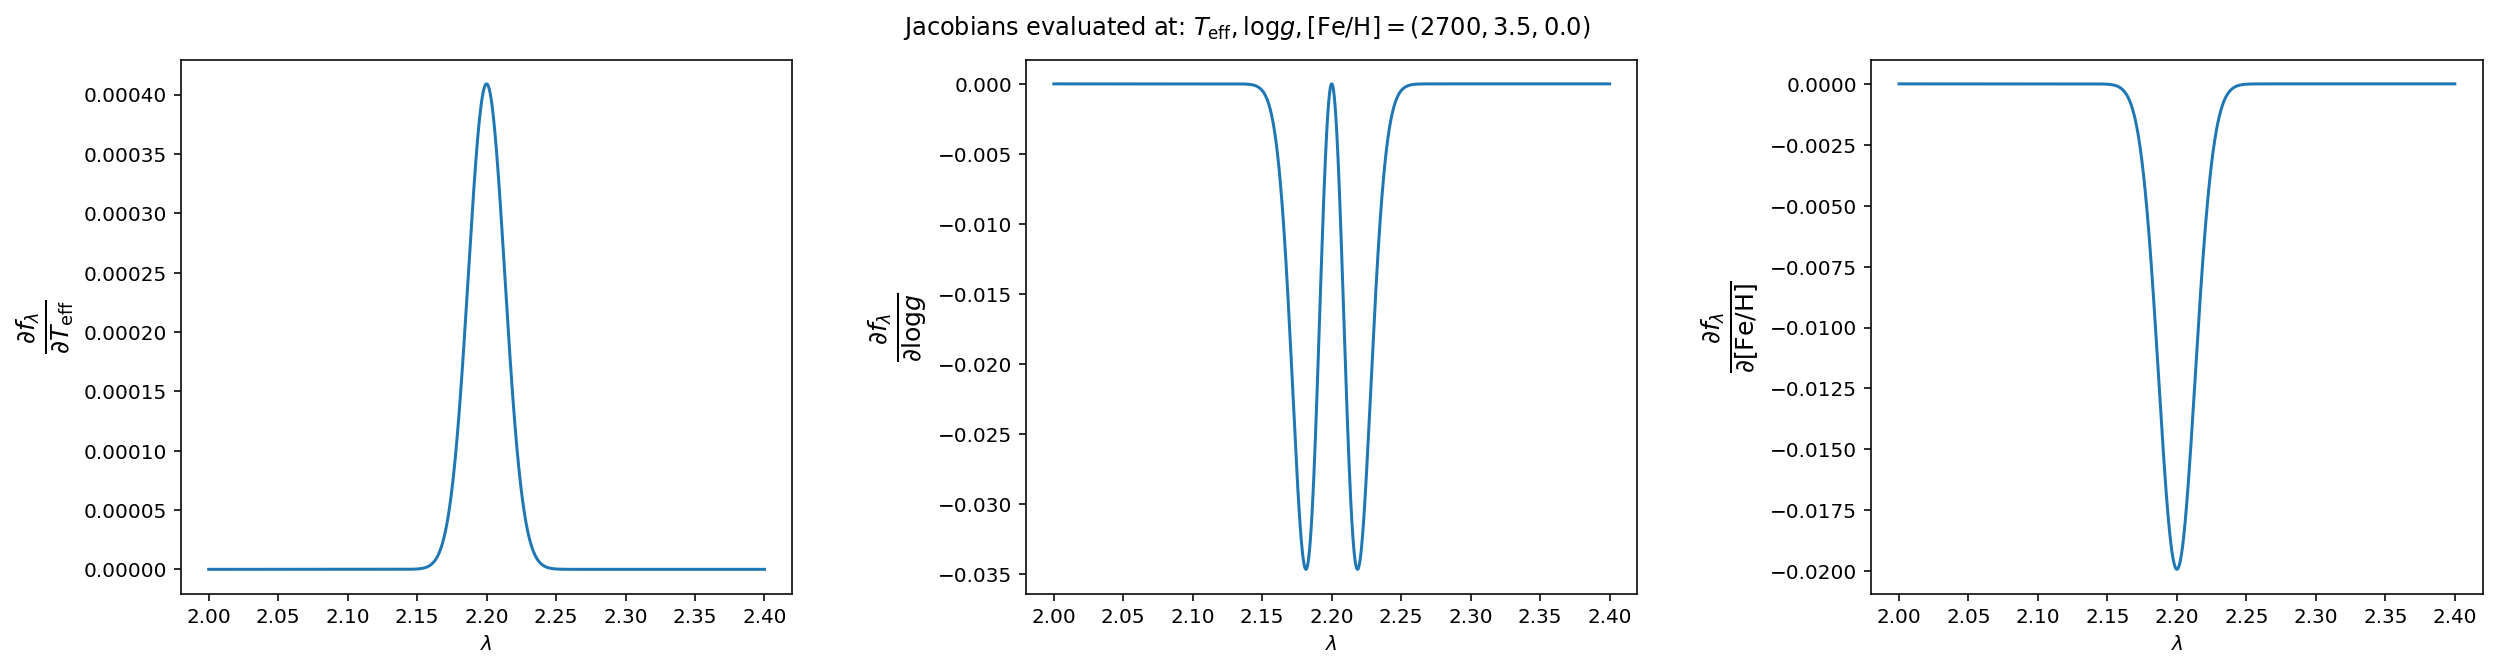

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, partial_derivative in enumerate(F_confounded): 
    axes[i].plot(wl,partial_derivative, label = labels[i]);
    axes[i].set_xlabel('$\lambda$'); axes[i].set_ylabel(labels[i], fontsize=18) 
fig.suptitle('Jacobians evaluated at: $T_{\mathrm{eff}}, \log{g}, [\mathrm{Fe}/{\mathrm{H}}] = (2700, 3.5, 0.0)$')
plt.tight_layout(pad=3);

Neat!  We kept track of the partial derivatives at each position!

## How about applying Jax to real data?  Can we use gradient descent of the likelihood function?

Let's generates some *fake data*, and attempt to fit the data with MCMC.  We expect to see degeneracies.

In [116]:
import numpy as np_original

In [114]:
true_parameters = (3217, 4.77, -1.62)

The observation will have a coarser wavelength sampling:

In [130]:
wl = np.linspace(2.0, 2.4, 200)

In [131]:
noiseless_signal = synthetic_spectrum_confounded(true_parameters)

In [139]:
noise = np_original.random.normal(0, 0.03, size=len(noiseless_signal))

In [140]:
fake_data = noiseless_signal + noise

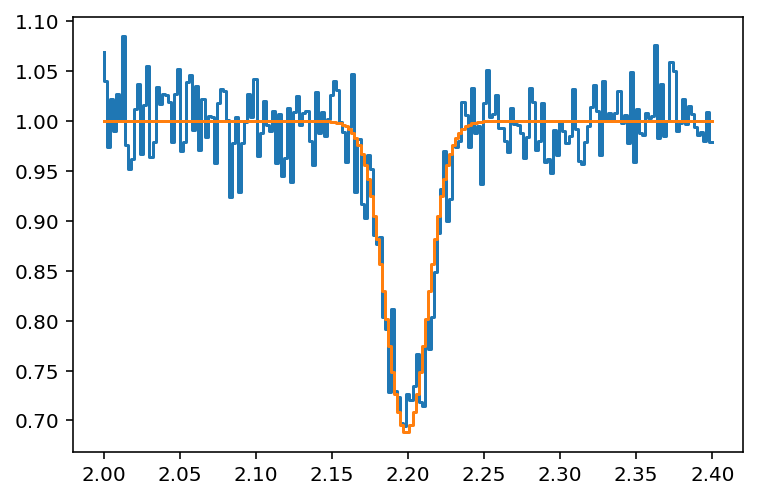

In [144]:
plt.step(wl, fake_data);
plt.step(wl, noiseless_signal);

Let's use `emcee` to fit this fake data.